In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import holidays
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load 60-min time series
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
df = pd.read_csv(url, index_col=0, parse_dates=True)

# Focus on German electricity demand
df = df[['DE_load_actual_entsoe_transparency']].dropna()
df.rename(columns={'DE_load_actual_entsoe_transparency': 'load_MW'}, inplace=True)

print(df.head())
print(df.index.min(), "to", df.index.max())

                           load_MW
utc_timestamp                     
2015-01-01 00:00:00+00:00  41151.0
2015-01-01 01:00:00+00:00  40135.0
2015-01-01 02:00:00+00:00  39106.0
2015-01-01 03:00:00+00:00  38765.0
2015-01-01 04:00:00+00:00  38941.0
2015-01-01 00:00:00+00:00 to 2020-09-30 23:00:00+00:00


In [3]:
# reset index, rename column, parse & drop tz, format
df = (
    df
    .reset_index()
    .rename(columns={'utc_timestamp': 'datetime'})
)
df['datetime'] = (
    pd.to_datetime(df['datetime'])
      .dt.tz_localize(None)             # drop tz
      .dt.strftime('%Y-%m-%d %H:%M:%S')  # format
)
# now df.datetime is your clean datetime column
df.set_index('datetime', inplace=True)

In [4]:
# 1) Timestamps where load_MW is null
null_timestamps = df[df['load_MW'].isna()].index
print("Null load at these datetimes:")
print(null_timestamps)

# 2) Monotonicity check
is_sorted = df.index.is_monotonic_increasing
print(f"Index sorted?: {is_sorted}")

# 3) Strictly increasing (no duplicates)
is_strict = is_sorted and df.index.is_unique
print(f"Strictly increasing (no duplicates)?: {is_strict}")

# 4) Find any duplicate timestamps
dup_mask = df.index.duplicated(keep=False)
duplicate_timestamps = df.index[dup_mask].unique()
print("Duplicate timestamps found:")
print(duplicate_timestamps)

Null load at these datetimes:
Index([], dtype='object', name='datetime')
Index sorted?: True
Strictly increasing (no duplicates)?: True
Duplicate timestamps found:
Index([], dtype='object', name='datetime')


In [5]:
df.index = pd.to_datetime(df.index)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # 0 = Monday
df['month'] = df.index.month
df['year'] = df.index.year
df['dow'] = df.index.dayofweek  # 0=Monday
# Optional: flag for weekend
df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)

# 2) Time features: daily and yearly cycles
timestamp_s = df.index.map(pd.Timestamp.timestamp)
day = 24 * 60 * 60
year = 365.2425 * day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [6]:
df

,load_MW,hour,dayofweek,month,year,dow,is_weekend,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,,,,,,
2015-01-01 00:00:00,41151.0,0,3,1,2015,3,0,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 01:00:00,40135.0,1,3,1,2015,3,0,2.588190e-01,0.965926,0.002222,0.999998
2015-01-01 02:00:00,39106.0,2,3,1,2015,3,0,5.000000e-01,0.866025,0.002939,0.999996
2015-01-01 03:00:00,38765.0,3,3,1,2015,3,0,7.071068e-01,0.707107,0.003656,0.999993
2015-01-01 04:00:00,38941.0,4,3,1,2015,3,0,8.660254e-01,0.500000,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,57559.0,19,2,9,2020,2,0,-9.659258e-01,0.258819,-0.999990,-0.004562
2020-09-30 20:00:00,54108.0,20,2,9,2020,2,0,-8.660254e-01,0.500000,-0.999993,-0.003846
2020-09-30 21:00:00,49845.0,21,2,9,2020,2,0,-7.071068e-01,0.707107,-0.999995,-0.003129


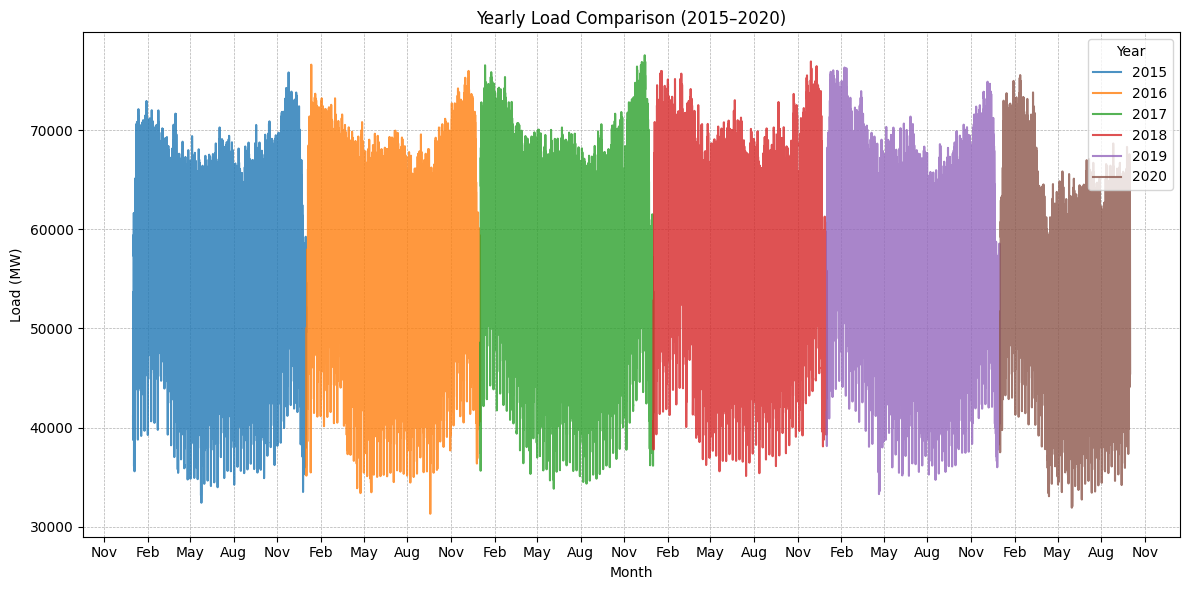

In [7]:
# 1) Set up a wider figure for readability
fig, ax = plt.subplots(figsize=(12, 6))
df.index = pd.to_datetime(df.index)

# 2) Plot each year with a bit more line weight
for year in range(2015, 2021):
    yearly = df[df.index.year == year]['load_MW']
    ax.plot(
        yearly.index,
        yearly.values,
        label=str(year),
        alpha=0.8,
        linewidth=1.5
    )

# 3) Use quarterly ticks, formatted as month abbreviations
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# 4) Labels, title, and a titled legend
ax.set_xlabel("Month")
ax.set_ylabel("Load (MW)")
ax.set_title("Yearly Load Comparison (2015–2020)")
ax.legend(title="Year", loc="upper right")

# 5) A light dashed grid for reference
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 6) Rotate only if needed and tighten
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
# 1a) ensure index is a tz-naive DatetimeIndex
df.index = pd.to_datetime(df.index).tz_localize(None)

# 1b) add a “time of day” column for grouping into 96 slots
df['time_of_day'] = df.index.time

# 1c) flag weekend vs. weekday (you already have is_weekend, but here’s one way)
df['is_weekend'] = df.index.weekday >= 5

# 1d) map months to seasons
season_map = {
    12: 'winter', 1: 'winter', 2: 'winter',
    3:  'spring', 4: 'spring', 5:  'spring',
    6:  'summer', 7: 'summer', 8:  'summer',
    9:  'autumn', 10:'autumn',11: 'autumn',
}
df['season'] = df.index.month.map(season_map)

# 1f) flag public holidays (German calendar; adjust country if needed)
de_holidays = holidays.Germany(years=range(df.index.year.min(), df.index.year.max()+1))
df['is_holiday'] = df.index.normalize().isin(de_holidays)


C:\Users\ashis\AppData\Local\Temp\ipykernel_5384\2084851916.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(de_holidays)


In [9]:
df

,load_MW,hour,dayofweek,month,year,dow,is_weekend,Day sin,Day cos,Year sin,Year cos,time_of_day,season,is_holiday
datetime,,,,,,,,,,,,,,
2015-01-01 00:00:00,41151.0,0,3,1,2015,3,False,1.232357e-12,1.000000,0.001505,0.999999,00:00:00,winter,True
2015-01-01 01:00:00,40135.0,1,3,1,2015,3,False,2.588190e-01,0.965926,0.002222,0.999998,01:00:00,winter,True
2015-01-01 02:00:00,39106.0,2,3,1,2015,3,False,5.000000e-01,0.866025,0.002939,0.999996,02:00:00,winter,True
2015-01-01 03:00:00,38765.0,3,3,1,2015,3,False,7.071068e-01,0.707107,0.003656,0.999993,03:00:00,winter,True
2015-01-01 04:00:00,38941.0,4,3,1,2015,3,False,8.660254e-01,0.500000,0.004372,0.999990,04:00:00,winter,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,57559.0,19,2,9,2020,2,False,-9.659258e-01,0.258819,-0.999990,-0.004562,19:00:00,autumn,False
2020-09-30 20:00:00,54108.0,20,2,9,2020,2,False,-8.660254e-01,0.500000,-0.999993,-0.003846,20:00:00,autumn,False
2020-09-30 21:00:00,49845.0,21,2,9,2020,2,False,-7.071068e-01,0.707107,-0.999995,-0.003129,21:00:00,autumn,False


In [10]:
def base_profile(group):
    """
    Given a DataFrameGroupBy object grouped by time_of_day,
    returns a Series of length 96 with the average load.
    """
    return group['load_MW'].groupby(df['time_of_day']).mean()

# A) Weekday vs Weekend
base_weekday = base_profile(df.loc[~df['is_weekend']])
base_weekend = base_profile(df.loc[ df['is_weekend']])

# B) Season-wise
base_by_season = {
    season: base_profile(df.loc[df['season'] == season])
    for season in ['winter','spring','summer','autumn']
}

# C) Year-wise
base_by_year = {
    year: base_profile(df.loc[df['year'] == year])
    for year in sorted(df['year'].unique())
}

# D) Holiday vs Non-holiday
base_holiday     = base_profile(df.loc[df['is_holiday']])
base_nonholiday  = base_profile(df.loc[~df['is_holiday']])

profiles = {}

# Week vs weekend
profiles['weekday'] = base_weekday
profiles['weekend'] = base_weekend

# Seasons
for season, prof in base_by_season.items():
    profiles[f'season_{season}'] = prof

# Years
for year, prof in base_by_year.items():
    profiles[f'year_{year}'] = prof

# Holidays
profiles['holiday']    = base_holiday
profiles['nonholiday'] = base_nonholiday

base_df = pd.DataFrame(profiles)


In [11]:
base_df

,weekday,weekend,season_winter,season_spring,season_summer,season_autumn,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,holiday,nonholiday
time_of_day,,,,,,,,,,,,,,
00:00:00,44843.438667,41478.570000,47994.679061,43149.289855,41100.094203,43549.193814,42870.232877,43566.240437,44344.391781,45354.824658,44640.279452,42063.886861,38993.076923,44006.181641
01:00:00,44651.182000,40807.666667,47050.285714,43044.481884,40994.208333,43359.422680,42528.857534,43220.191257,44035.197260,44992.769863,44307.353425,41796.927007,38433.576923,43683.020996
02:00:00,45499.806000,40718.268333,47111.375734,43878.905797,41644.306159,44119.472165,43124.150685,43806.650273,44635.057534,45529.904110,44895.189041,42372.868613,38346.307692,44280.596680
03:00:00,47978.140000,40879.793333,48010.487280,45790.722826,43770.849638,46440.698969,44954.534247,45643.527322,46460.972603,47350.800000,46683.720548,44161.660584,38217.384615,46146.377930
04:00:00,53579.612000,41511.343333,50103.369863,49898.376812,49211.422101,51473.800000,49149.498630,49908.442623,50683.904110,51626.024658,50816.673973,48098.383212,38010.269231,50439.301758
05:00:00,59786.766000,43180.311667,55079.542074,54507.706522,54205.302536,56563.111340,54220.076712,54970.934426,55652.906849,56578.052055,55652.213699,52559.445255,39055.980769,55447.961426
06:00:00,63940.452667,46290.395000,60083.336595,57992.617754,57637.483696,60112.402062,58194.915068,58918.106557,59636.526027,60388.542466,59356.057534,56224.941606,41698.807692,59334.266602
07:00:00,65515.423333,49435.466667,62778.772994,59921.739130,59431.670290,61796.659794,60258.871233,60988.707650,61682.934247,62407.939726,61254.917808,58273.160584,44472.576923,61338.789551
08:00:00,66532.346000,51906.235000,64137.409002,61302.632246,61164.347826,63023.239175,61710.920548,62491.587432,63148.120548,63734.753425,62584.257534,59818.795620,46946.153846,62744.658203


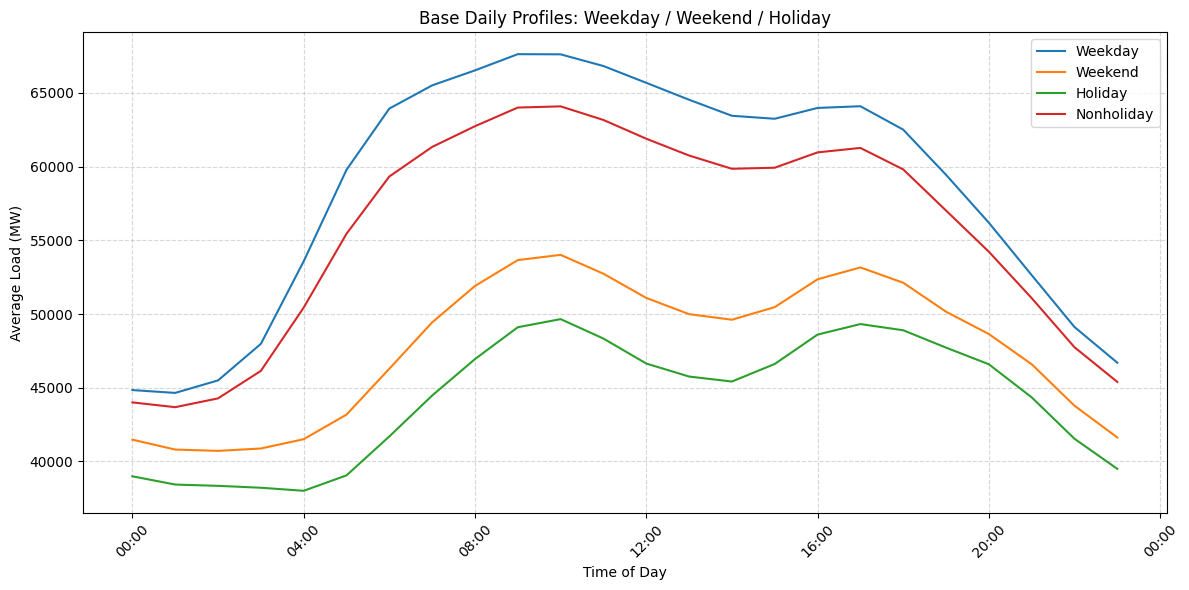

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

# convert base_df index (datetime.time objects) to datetime objects with a common arbitrary date
x_values = pd.to_datetime(base_df.index.astype(str), format='%H:%M:%S')

for label in ['weekday','weekend','holiday','nonholiday', ]:
    ax.plot(
        x_values, 
        base_df[label], 
        label=label.capitalize(), 
        linewidth=1.5
    )

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,4)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel("Time of Day")
ax.set_ylabel("Average Load (MW)")
ax.set_title("Base Daily Profiles: Weekday / Weekend / Holiday")
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
df

,load_MW,hour,dayofweek,month,year,dow,is_weekend,Day sin,Day cos,Year sin,Year cos,time_of_day,season,is_holiday
datetime,,,,,,,,,,,,,,
2015-01-01 00:00:00,41151.0,0,3,1,2015,3,False,1.232357e-12,1.000000,0.001505,0.999999,00:00:00,winter,True
2015-01-01 01:00:00,40135.0,1,3,1,2015,3,False,2.588190e-01,0.965926,0.002222,0.999998,01:00:00,winter,True
2015-01-01 02:00:00,39106.0,2,3,1,2015,3,False,5.000000e-01,0.866025,0.002939,0.999996,02:00:00,winter,True
2015-01-01 03:00:00,38765.0,3,3,1,2015,3,False,7.071068e-01,0.707107,0.003656,0.999993,03:00:00,winter,True
2015-01-01 04:00:00,38941.0,4,3,1,2015,3,False,8.660254e-01,0.500000,0.004372,0.999990,04:00:00,winter,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,57559.0,19,2,9,2020,2,False,-9.659258e-01,0.258819,-0.999990,-0.004562,19:00:00,autumn,False
2020-09-30 20:00:00,54108.0,20,2,9,2020,2,False,-8.660254e-01,0.500000,-0.999993,-0.003846,20:00:00,autumn,False
2020-09-30 21:00:00,49845.0,21,2,9,2020,2,False,-7.071068e-01,0.707107,-0.999995,-0.003129,21:00:00,autumn,False


### Data Preprocessing for Model Training

In [14]:
df_model = df.copy()
df_model['is_weekend'] = df_model['is_weekend'].astype(int)
df_model['is_holiday'] = df_model['is_holiday'].astype(int)

# Drop non-numeric or unnecessary columns
df_model = df_model.drop(columns=['time_of_day', 'season'])

### Splitting and Scaling the data

In [15]:
# --- 2) Train/Validation/Test split (70/15/15 by chronological order) ---
n_samples = len(df_model)
train_end = int(n_samples * 0.70)
val_end   = int(n_samples * 0.85)

train_df = df_model.iloc[:train_end]
val_df   = df_model.iloc[train_end:val_end]
test_df  = df_model.iloc[val_end:]

# --- 3) Scaling with MinMaxScaler fit only on train ---
scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = pd.DataFrame(scaler.transform(train_df),
                            index=train_df.index,
                            columns=train_df.columns)
val_scaled   = pd.DataFrame(scaler.transform(val_df),
                            index=val_df.index,
                            columns=val_df.columns)
test_scaled  = pd.DataFrame(scaler.transform(test_df),
                            index=test_df.index,
                            columns=test_df.columns)

### Sequence creation for LSTM

In [16]:
# --- 4) Sequence creation for LSTM ---
def create_sequences(df_, input_len=168, output_len=24):
    X, y = [], []
    for i in range(len(df_) - input_len - output_len + 1):
        X.append(df_.iloc[i : i + input_len].values)
        y.append(df_['load_MW'].iloc[i + input_len : i + input_len + output_len].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_val,   y_val   = create_sequences(pd.concat([train_scaled.tail(672), val_scaled]))
X_test,  y_test  = create_sequences(pd.concat([val_scaled.tail(672), test_scaled]))

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

Shapes:
X_train: (35089, 168, 12) y_train: (35089, 24)
X_val:   (8041, 168, 12) y_val:   (8041, 24)
X_test:  (8041, 168, 12) y_test:  (8041, 24)


In [17]:
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1) Build model constructors
def build_lstm(input_shape, output_size):
    m = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(output_size)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

def build_gru(input_shape, output_size):
    m = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(output_size)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

def build_cnn(input_shape, output_size):
    m = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(output_size)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

# 2) Instantiate all three
models = {
    'LSTM':  build_lstm((168, X_train.shape[2]), y_train.shape[1]),
    'GRU':   build_gru ((168, X_train.shape[2]), y_train.shape[1]),
    'Conv1D':build_cnn ((168, X_train.shape[2]), y_train.shape[1]),
}

# Ensure checkpoint directory exists
os.makedirs('model_checkpoints', exist_ok=True)

# 3) Train + evaluate with EarlyStopping and ModelCheckpoint
histories = {}
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Define callbacks
    checkpoint_path = f"model_checkpoints/best_{name}.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', 
                        save_best_only=True, verbose=1)
    ]
    
    # Train
    t0 = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    train_time = time.time() - t0
    
    histories[name] = history
    print(f"{name} training completed in {train_time:.1f}s. Best model saved to {checkpoint_path}")
    
    # Predict on test
    y_pred = model.predict(X_test, verbose=0)
    
    # Compute metrics
    mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
    
    results.append({
        'model': name,
        'train_time_sec': round(train_time, 1),
        'test_MSE': mse,
        'test_MAE': mae,
        'checkpoint': checkpoint_path
    })

c:\Users\ashis\miniconda3\envs\slp\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ashis\miniconda3\envs\slp\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training LSTM...
Epoch 1/20
1096/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0328
Epoch 1: val_loss improved from inf to 0.00376, saving model to model_checkpoints/best_LSTM.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0328 - val_loss: 0.0038
Epoch 2/20
1096/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032
Epoch 2: val_loss did not improve from 0.00376
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 3/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026
Epoch 3: val_loss improved from 0.00376 to 0.00257, saving model to model_checkpoints/best_LSTM.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0023
Epoch 4: val_loss improved from 0.00257 to 0.00227, saving model to model_checkpoints/best_LSTM.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/20
1096/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0023
Epoch 5: val_loss did not improve from 0.00227
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 6/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0020
Epoch 6: val_loss did not improve from 0.00227
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 7/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0020
Epoch 7: val_loss improved from 0.00227 to 0.00203, saving model to model_checkpoints/best_LSTM.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0018
Epoch 8: val_loss did not improve from 0.00203
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 9/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0017
Epoch 9: val_loss improved from 0.00203 to 0.00178, saving model to model_checkpoints/best_LSTM.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0017
Epoch 10: val_loss did not improve from 0.00178
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0016
Epoch 11: val_loss did not improve from 0.00178
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 12/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0016
Epoch 12: val_loss did not improve from 0.00178
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0016 - val_loss: 0.0019
LSTM training completed in 441.6s. Best model saved to model_checkpoints/best_LSTM.h5

Training GRU...
Epoch 1/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0288
Epoch 1: val_loss improved from inf to 0.00397, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 0.0287 - val_loss: 0.0040
Epoch 2/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0035
Epoch 2: val_loss improved from 0.00397 to 0.00278, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0028
Epoch 3: val_loss did not improve from 0.00278
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 4/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0025
Epoch 4: val_loss improved from 0.00278 to 0.00253, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0023
Epoch 5: val_loss improved from 0.00253 to 0.00230, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0021
Epoch 6: val_loss did not improve from 0.00230
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 7/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0021
Epoch 7: val_loss improved from 0.00230 to 0.00217, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0019
Epoch 8: val_loss improved from 0.00217 to 0.00196, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0018
Epoch 9: val_loss improved from 0.00196 to 0.00193, saving model to model_checkpoints/best_GRU.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0017
Epoch 10: val_loss did not improve from 0.00193
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 11/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0017
Epoch 11: val_loss did not improve from 0.00193
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 12/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0017
Epoch 12: val_loss did not improve from 0.00193
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 0.0017 - val_loss: 0.0020
GRU training completed in 535.7s. Best model saved to model_checkpoints/best_GRU.h5

Training Conv1D...
Epoch 1/20
1095/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257
Epoch 1: val_loss improved from inf to 0.00360, saving model to model_checkpoints/best_Conv1D.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0257 - val_loss: 0.0036
Epoch 2/20
1094/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 2: val_loss improved from 0.00360 to 0.00296, saving model to model_checkpoints/best_Conv1D.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 3/20
1094/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 3: val_loss improved from 0.00296 to 0.00270, saving model to model_checkpoints/best_Conv1D.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 4/20
1096/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 4: val_loss improved from 0.00270 to 0.00245, saving model to model_checkpoints/best_Conv1D.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 5/20
1094/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 5: val_loss improved from 0.00245 to 0.00242, saving model to model_checkpoints/best_Conv1D.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 6/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 6: val_loss did not improve from 0.00242
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 7/20
1094/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 7: val_loss did not improve from 0.00242
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 8/20
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 8: val_loss improved from 0.00242 to 0.00217, saving model to model_checkpoints/best_Conv1D.h5


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 9/20
1096/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 9: val_loss did not improve from 0.00217
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 10/20
1094/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 10: val_loss did not improve from 0.00217
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 11/20
1095/1097 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 11: val_loss did not improve from 0.00217
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0014 - val_loss: 0.0041
Conv1D training completed in 164.1s. Best model saved to model_checkpoints/best_Conv1D.h5


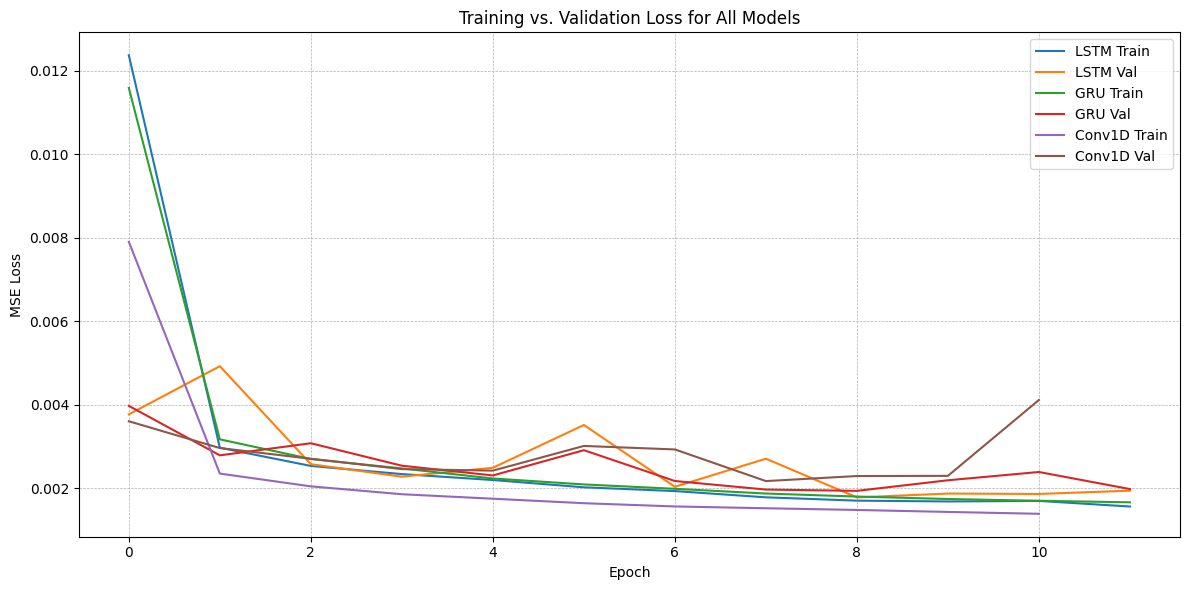

In [18]:
# 5) Plot training & validation loss curves
fig, ax = plt.subplots(figsize=(12, 6))
for name, hist in histories.items():
    ax.plot(hist.history['loss'],     label=f"{name} Train")
    ax.plot(hist.history['val_loss'], label=f"{name} Val")

ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training vs. Validation Loss for All Models")
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

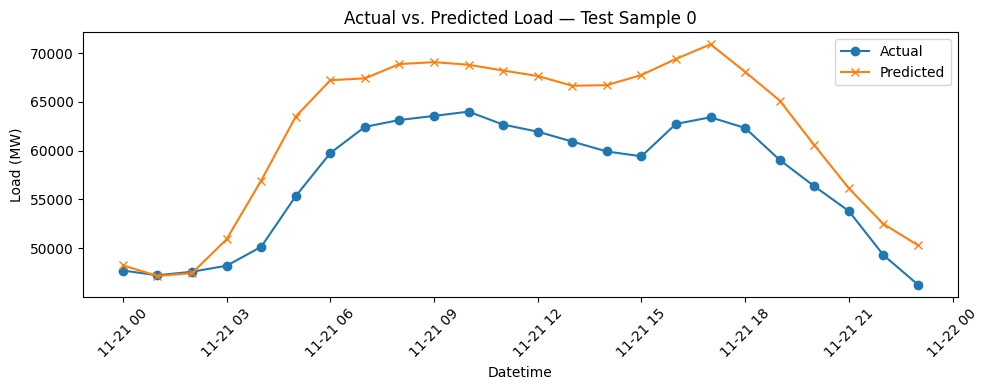

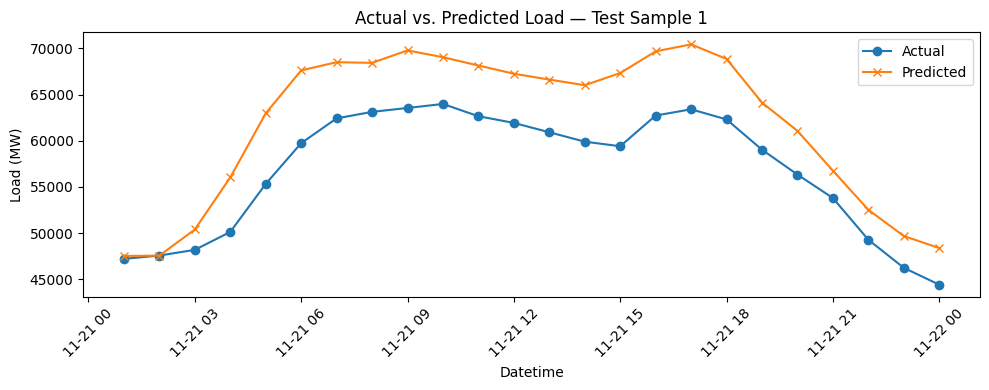

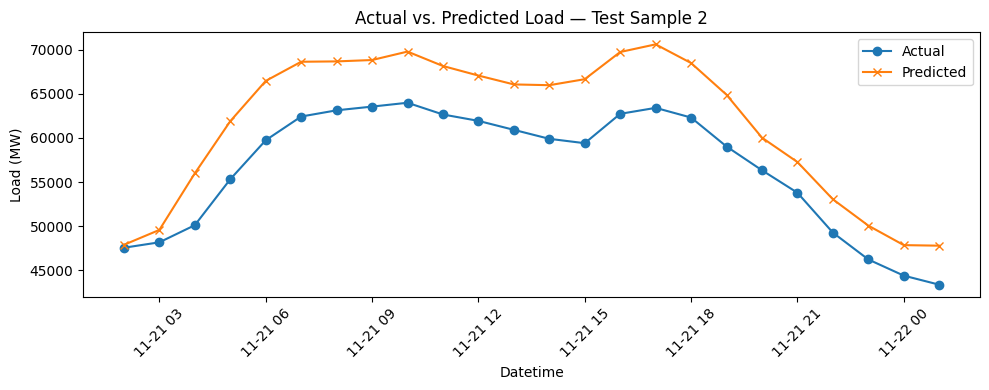

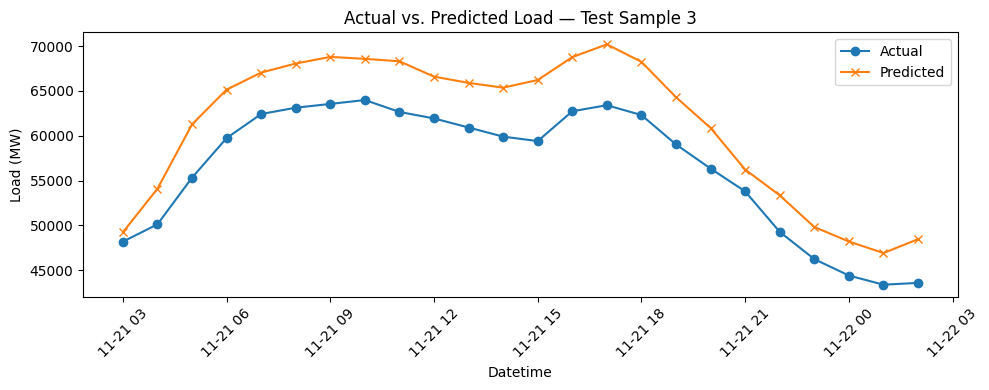

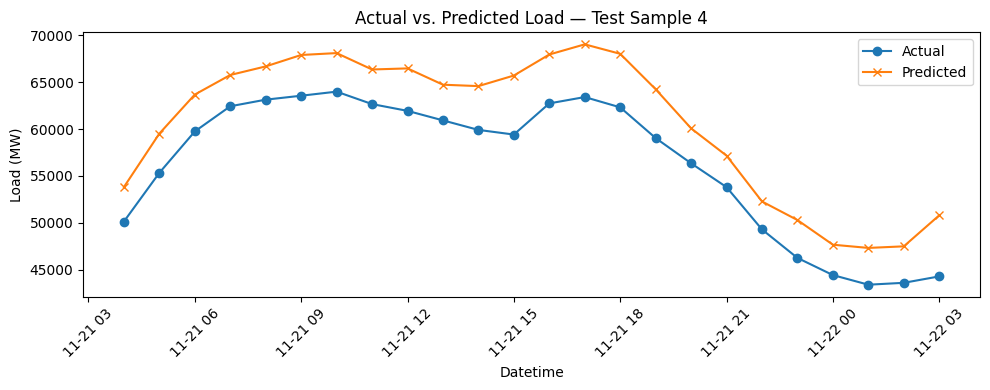

In [19]:

# 1) Invert the MinMax scaling for load_MW only
col_idx   = train_df.columns.get_loc('load_MW')
min_val   = scaler.data_min_[col_idx]
max_val   = scaler.data_max_[col_idx]

y_test_inv = y_test * (max_val - min_val) + min_val
y_pred_inv = y_pred * (max_val - min_val) + min_val

# 2) Helper to plot a single sample
def plot_actual_vs_pred(i):
    """
    Plots the i-th test sample:
     - y_test_inv[i] vs y_pred_inv[i]
     - time axis from test_scaled.index
    """
    horizon = y_test.shape[1]             # 24
    times   = test_scaled.index[i : i + horizon]

    plt.figure(figsize=(10, 4))
    plt.plot(times, y_test_inv[i],  marker='o', label='Actual')
    plt.plot(times, y_pred_inv[i],  marker='x', label='Predicted')
    plt.title(f'Actual vs. Predicted Load — Test Sample {i}')
    plt.xlabel('Datetime')
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3) Plot the first three test samples
for sample_idx in range(5):
    plot_actual_vs_pred(sample_idx)


In [20]:
# Rebuild the DataFrame of results
results_df = pd.DataFrame(results).set_index('model')

# Metrics to visualize
metrics = ['train_time_sec', 'test_MSE', 'test_MAE']

In [21]:
results_df

,train_time_sec,test_MSE,test_MAE,checkpoint
model,,,,
LSTM,441.6,0.002788,0.036275,model_checkpoints/best_LSTM.h5
GRU,535.7,0.002678,0.036671,model_checkpoints/best_GRU.h5
Conv1D,164.1,0.005068,0.054221,model_checkpoints/best_Conv1D.h5


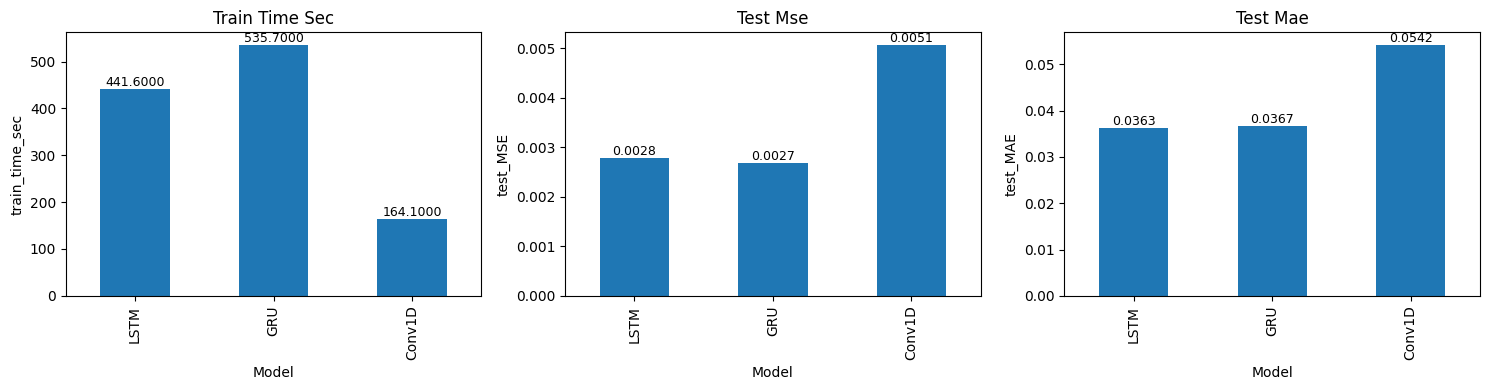

In [22]:
# One subplot per metric
fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 4))

for ax, metric in zip(axes, metrics):
    # Bar plot of the metric across models
    results_df[metric].plot(kind='bar', ax=ax)
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    # Annotate each bar with its value
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.4f}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=9
        )

plt.tight_layout()
plt.show()

In [23]:
import joblib
results_df.to_csv("results_df.csv")
joblib.dump(scaler, "scaler.pkl")
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
